# This is an unstructured guide for building a temporal AI agent (No Theory Included)

In [ ]:
# Import the necessary loader from the langchain_community package
from langchain_community.document_loaders import HuggingFaceDatasetLoader

hf_dataset_name = "jlh-ibm/earnings_call"
# The 'name' parameter in the loader corresponds to the subset
subset_name = "transcripts"

# Instantiate the loader with the path and name of the dataset
# By default, it loads the 'train' split, which is what the notebook does.
loader = HuggingFaceDatasetLoader(path=hf_dataset_name, name=subset_name, page_content_column="transcript")

In [2]:
# This is the key step. The loader processes the dataset and returns a list of LangChain Document objects.
documents = loader.load()

c:\Users\faree\Desktop\temporal_ai_agent_knw\.venv-temporal-logic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\faree\Desktop\temporal_ai_agent_knw\.venv-temporal-logic\lib\site-packages\datasets\load.py:2566: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


In [3]:
# Let's inspect the result to see the difference
print(f"Loaded {len(documents)} documents.")

Loaded 188 documents.


In [4]:
# print metadata of random document
print(documents[0].metadata)
print(documents[33].metadata)

{'company': 'AMD', 'date': datetime.date(2016, 7, 21)}
{'company': 'AMZN', 'date': datetime.date(2019, 10, 24)}


In [5]:
# loop through documents and value counts company
company_counts = {}
for doc in documents:
    company = doc.metadata.get("company")
    if company:
        company_counts[company] = company_counts.get(company, 0) + 1

print("Total company counts:")
for company, count in company_counts.items():
    print(f" - {company}: {count}")

Total company counts:
 - AMD: 19
 - AAPL: 19
 - INTC: 19
 - MU: 17
 - GOOGL: 19
 - ASML: 19
 - CSCO: 19
 - NVDA: 19
 - AMZN: 19
 - MSFT: 19


In [6]:
# Printing first doc 200 characters
first_doc = documents[0]
print(first_doc.page_content[:200])

"\n\nThomson Reuters StreetEvents Event Transcript\nE D I T E D   V E R S I O N\n\nQ2 2016 Advanced Micro Devices Inc Earnings Call\nJULY 21, 2016 / 9:00PM GMT\n\n=====================================


In [7]:
# check number of words in first_doc
first_doc = documents[0]
num_words = len(first_doc.page_content.split())
print(f"Number of words in the first document: {num_words}")

Number of words in the first document: 8463


In [8]:
# check average number of words in all documents
total_words = sum(len(doc.page_content.split()) for doc in documents)
average_words = total_words / len(documents) if documents else 0
print(f"Average number of words in documents: {average_words}")

Average number of words in documents: 8797.186170212766


In [ ]:
import re
from datetime import datetime

def find_quarter(text: str) -> str | None:
    """Extract the quarter (e.g., 'Q1 2023') from the input text if present."""
    search_results = re.findall(r"[Q]\d\s\d{4}", text)
    if search_results:
        return str(search_results[0])
    return None

# Let's test it on our first document
quarter = find_quarter(documents[0].page_content)
print(f"Extracted Quarter for the first document: {quarter}")

Extracted Quarter for the first document: Q2 2016


In [ ]:
import os
from langchain_nebius import NebiusEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
langchain_semantic_chunker = SemanticChunker(
    embeddings, breakpoint_threshold_type="percentile"
)
from langchain_core.documents import Document
from tqdm import tqdm


os.environ["NEBIUS_API_KEY"] = "YOUR_API_KEY"


# 1. Initialize the OpenAI embedding model, same as before
embeddings = NebiusEmbeddings(model="Qwen/Qwen3-Embedding-8B")

# 2. Instantiate LangChain's SemanticChunker
# It takes the embeddings object directly.
# We can use the "percentile" threshold, which is often more robust than a fixed number.
# It means a break is added at sentence pairs where the semantic distance is in the 95th percentile.
langchain_semantic_chunker = SemanticChunker(
    embeddings, breakpoint_threshold_type="percentile"
)

# We'll store the new, smaller chunk documents here
chunked_documents_lc = []

# Filter for just AMD and NVDA documents (same as before)
target_companies = ["AMD", "NVDA"]
docs_to_process = [doc for doc in documents if doc.metadata.get("company") in target_companies]

# sample 1 document from the filtered list
docs_to_process = docs_to_process[:1]

print(f"Processing {len(docs_to_process)} documents using LangChain's SemanticChunker...")

# Loop through each transcript document and chunk it
for doc in tqdm(docs_to_process, desc="Chunking Transcripts with LangChain"):
    # 1. Extract quarter and prepare metadata (same as before)
    quarter = find_quarter(doc.page_content)
    parent_metadata = doc.metadata.copy()
    parent_metadata["quarter"] = quarter

    # 2. Perform semantic chunking using the LangChain chunker's `create_documents` method
    # This is convenient as it directly returns Document objects.
    # We pass the metadata to be attached to each new chunk.
    chunks = langchain_semantic_chunker.create_documents([doc.page_content], metadatas=[parent_metadata])
    
    # 3. Add the returned chunk Documents to our list
    chunked_documents_lc.extend(chunks)

print("\nChunking complete.")

Processing 1 documents using LangChain's SemanticChunker...


Chunking Transcripts with LangChain: 100%|██████████| 1/1 [03:44<00:00, 224.91s/it]


Chunking complete.


In [21]:
# Analysis of the LangChain chunking process
original_doc_count = len(docs_to_process)
chunked_doc_count = len(chunked_documents_lc)

print(f"Original number of documents (transcripts): {original_doc_count}")
print(f"Number of new documents (chunks): {chunked_doc_count}")
print(f"Average chunks per transcript: {chunked_doc_count / original_doc_count:.2f}")

print("\n--- Inspecting a sample chunk ---")
sample_chunk = chunked_documents_lc[10] # Let's look at the 11th chunk
print("Sample Chunk Content (first 300 chars):")
print(sample_chunk.page_content[:300] + "...")
print("\nSample Chunk Metadata:")
print(sample_chunk.metadata)

# Let's check the average word count of the new chunks
total_chunk_words = sum(len(doc.page_content.split()) for doc in chunked_documents_lc)
average_chunk_words = total_chunk_words / chunked_doc_count if chunked_documents_lc else 0

print(f"\nAverage number of words per chunk: {average_chunk_words:.2f}")

Original number of documents (transcripts): 1
Number of new documents (chunks): 19
Average chunks per transcript: 19.00

--- Inspecting a sample chunk ---
Sample Chunk Content (first 300 chars):
No, that's a fair question, Matt. So we have been very focused on the server launch for first half of 2017. Desktop should launch before that. In terms of true volume availability, I believe it will be in the first quarter of 2017. We may ship some limited volume towards the end of the fourth quarte...

Sample Chunk Metadata:
{'company': 'AMD', 'date': datetime.date(2016, 7, 21), 'quarter': 'Q2 2016'}

Average number of words per chunk: 445.42


In [ ]:
from enum import Enum
from pydantic import BaseModel, field_validator
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from tqdm import tqdm

# Since you're on Python 3.10, we'll define enums by inheriting from str and Enum.
# This provides the same behavior as StrEnum from Python 3.11.
class TemporalType(str, Enum):
    """Enumeration of temporal types of statements."""
    ATEMPORAL = "ATEMPORAL"
    STATIC = "STATIC"
    DYNAMIC = "DYNAMIC"

class StatementType(str, Enum):
    """Enumeration of statement types for statements."""
    FACT = "FACT"
    OPINION = "OPINION"
    PREDICTION = "PREDICTION"

class RawStatement(BaseModel):
    """Model representing a raw statement with type and temporal information."""
    statement: str
    statement_type: StatementType
    temporal_type: TemporalType

    @field_validator("temporal_type", mode="before")
    @classmethod
    def _parse_temporal_label(cls, value: str | None) -> TemporalType:
        if value is None:
            return TemporalType.ATEMPORAL
        cleaned_value = value.strip().upper()
        try:
            return TemporalType(cleaned_value)
        except ValueError:
            # Pydantic will catch this and raise a validation error
            raise ValueError(f"Invalid temporal type: {value}")

    @field_validator("statement_type", mode="before")
    @classmethod
    def _parse_statement_label(cls, value: str | None = None) -> StatementType:
        if value is None:
            return StatementType.FACT
        cleaned_value = value.strip().upper()
        try:
            return StatementType(cleaned_value)
        except ValueError:
            # Pydantic will catch this and raise a validation error
            raise ValueError(f"Invalid statement type: {value}")

class RawStatementList(BaseModel):
    """A container for the list of statements extracted from a single chunk."""
    statements: list[RawStatement]

print("Pydantic models for statement extraction have been defined and are Python 3.10 compatible.")

Pydantic models for statement extraction have been defined and are Python 3.10 compatible.


In [31]:
# These definitions provide the necessary context for the LLM to understand the labels.
LABEL_DEFINITIONS: dict[str, dict[str, dict[str, str]]] = {
    "episode_labelling": {
        "FACT": dict(definition="Statements that are objective and can be independently verified or falsified through evidence."),
        "OPINION": dict(definition="Statements that contain personal opinions, feelings, values, or judgments that are not independently verifiable."),
        "PREDICTION": dict(definition="Uncertain statements about the future on something that might happen, a hypothetical outcome, unverified claims."),
    },
    "temporal_labelling": {
        "STATIC": dict(definition="Often past tense, think -ed verbs, describing single points-in-time."),
        "DYNAMIC": dict(definition="Often present tense, think -ing verbs, describing a period of time."),
        "ATEMPORAL": dict(definition="Statements that will always hold true regardless of time."),
    },
}

# This is the corrected prompt template. Notice the double curly braces {{ and }} in the JSON example.
statement_extraction_prompt_template_fixed = """
You are an expert finance professional and information-extraction assistant.

===Inputs===
- main_entity: {main_entity}
- publication_date: {publication_date}
- document_chunk: {document_chunk}

===Tasks===
1. Identify and extract atomic declarative statements from the document_chunk.
2. For each statement, label it as FACT, OPINION, or PREDICTION.
3. For each statement, label it temporally as STATIC, DYNAMIC, or ATEMPORAL.

===Extraction Guidelines===
- Each statement should express a single, complete subject-predicate-object relationship.
- Resolve co-references (e.g., "the company" -> "{main_entity}").
- Include any explicit dates or quantitative qualifiers.

===Label Definitions===
{definitions}

===Example===
Chunk: "On April 1st, 2024, John Smith was appointed CFO of TechNova Inc. He is currently overseeing the company’s global restructuring initiative."
Output: {{
  "statements": [
    {{
      "statement": "John Smith was appointed CFO of TechNova Inc on April 1st, 2024.",
      "statement_type": "FACT",
      "temporal_type": "STATIC"
    }},
    {{
      "statement": "John Smith is currently overseeing TechNova Inc's global restructuring initiative.",
      "statement_type": "FACT",
      "temporal_type": "DYNAMIC"
    }}
  ]
}}
===End of Example===

**Output format**
Return ONLY a valid JSON object matching the schema for `RawStatementList`.
"""

# Create the ChatPromptTemplate from the fixed string.
prompt = ChatPromptTemplate.from_template(statement_extraction_prompt_template_fixed)

# We still need to format the definitions_text to pass into the invoke call.
definitions_text = ""
for section_key, section_dict in LABEL_DEFINITIONS.items():
    definitions_text += f"==== {section_key.replace('_', ' ').upper()} DEFINITIONS ====\n"
    for category, details in section_dict.items():
        definitions_text += f"- {category}: {details.get('definition', '')}\n"

print("Prompt template for statement extraction has been correctly created.")

Prompt template for statement extraction has been correctly created.


In [32]:
import os
from langchain_nebius import ChatNebius

# We'll use a powerful model as recommended by the notebook for this complex extraction task.
# Replace with your desired LLM provider if needed.
# For this example, let's assume we are using a powerful OpenAI model via Nebius or directly
# The LLM and chain definition are the same.
llm = ChatNebius(model="deepseek-ai/DeepSeek-V3")
statement_extraction_chain = prompt | llm.with_structured_output(RawStatementList)

# Let's use the same sample chunk
sample_chunk_for_extraction = chunked_documents_lc[0]

print("--- Running statement extraction on a sample chunk (with fixed prompt) ---")
print(f"Chunk Content:\n{sample_chunk_for_extraction.page_content}")
print("\nInvoking LLM for extraction...")

# Run the chain, passing ALL variables, including definitions, in the dictionary.
extracted_statements_list = statement_extraction_chain.invoke({
    "main_entity": sample_chunk_for_extraction.metadata["company"],
    "publication_date": sample_chunk_for_extraction.metadata["date"].isoformat(),
    "document_chunk": sample_chunk_for_extraction.page_content,
    "definitions": definitions_text # Pass the definitions text here
})

print("\n--- Extraction Result ---")
import json
print(json.dumps(extracted_statements_list.dict(), indent=2))

--- Running statement extraction on a sample chunk (with fixed prompt) ---
Chunk Content:
"\n\nThomson Reuters StreetEvents Event Transcript\nE D I T E D   V E R S I O N\n\nQ2 2016 Advanced Micro Devices Inc Earnings Call\nJULY 21, 2016 / 9:00PM GMT\n\n================================================================================\nCorporate Participants\n================================================================================\n\n * Lisa Su\n   Advanced Micro Devices, Inc. - President and CEO\n * Devinder Kumar\n   Advanced Micro Devices, Inc. - SVP, CFO and Treasurer\n * Ruth Cotter\n   Advanced Micro Devices, Inc. - Chief Human Resources Officer and SVP of Corporate Communications and IR\n\n================================================================================\nConference Call Participiants\n================================================================================\n\n * Matt Ramsay\n   Canaccord Genuity - Analyst\n * Jaguar Bajwa\n   Arete Research - Analyst

C:\Users\faree\AppData\Local\Temp\ipykernel_7320\3015287349.py:28: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  print(json.dumps(extracted_statements_list.dict(), indent=2))


In [33]:
from datetime import datetime, timezone
from pydantic import Field
from dateutil.parser import parse

# This helper function is crucial for robust date parsing and is Python 3.10 compatible.
def parse_date_str(value: str | datetime | None) -> datetime | None:
    if not value:
        return None
    if isinstance(value, datetime):
        return value if value.tzinfo else value.replace(tzinfo=timezone.utc)
    try:
        # Handle simple YYYY format
        if re.fullmatch(r"\d{4}", value.strip()):
            year = int(value.strip())
            return datetime(year, 1, 1, tzinfo=timezone.utc)
        # General purpose parsing
        dt: datetime = parse(value)
        # Assume UTC if no timezone is present
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        return dt
    except Exception:
        return None

# These Pydantic models will structure the output of our date extraction LLM call.
class RawTemporalRange(BaseModel):
    """Model representing the raw temporal validity range as strings from the LLM."""
    valid_at: str | None = Field(None, description="The start date/time of the event's validity in ISO 8601 format.")
    invalid_at: str | None = Field(None, description="The end date/time of the event's validity in ISO 8601 format.")

class TemporalValidityRange(BaseModel):
    """Model representing the parsed and validated temporal range as datetime objects."""
    valid_at: datetime | None = None
    invalid_at: datetime | None = None

    @field_validator("valid_at", "invalid_at", mode="before")
    @classmethod
    def _parse_date_string(cls, value: str | datetime | None) -> datetime | None:
        # This validator automatically uses our robust parse_date_str function.
        return parse_date_str(value)

print("Pydantic models and helper function for temporal range extraction are defined.")

Pydantic models and helper function for temporal range extraction are defined.


In [ ]:
date_extraction_prompt_template = """
You are a temporal information extraction specialist.

INPUTS:
- statement: "{statement}"
- statement_type: "{statement_type}"
- temporal_type: "{temporal_type}"
- publication_date: "{publication_date}"
- quarter: "{quarter}"

TASK:
- Analyze the statement and determine the temporal validity range (valid_at, invalid_at).
- Use the publication date as the reference point for relative expressions (e.g., "last month", "currently").
- If a relationship is ongoing or its end is not specified, `invalid_at` should be null.

GUIDANCE:
- For STATIC statements, `invalid_at` is usually null. The `valid_at` is the date the event occurred.
- For DYNAMIC statements, `valid_at` is when the state began, and `invalid_at` is when it ended.
- Return all dates in ISO 8601 format (e.g., YYYY-MM-DDTHH:MM:SSZ).
- If only a year is mentioned, use the first day of that year (YYYY-01-01T00:00:00Z).

**Output format**
Return ONLY a valid JSON object matching the schema for `RawTemporalRange`.
"""

# Create the LangChain prompt and chain for date extraction.
date_extraction_prompt = ChatPromptTemplate.from_template(date_extraction_prompt_template)
date_extraction_chain = date_extraction_prompt | llm.with_structured_output(RawTemporalRange)

print("Date extraction chain created successfully.")

Date extraction chain created successfully.


In [ ]:
# Let's take the second statement from our previous result: "Lisa Su is the President and CEO of AMD."
# The original model classified it as STATIC, let's see how our date extraction handles it.
# The date extraction logic should still work correctly based on the provided labels.
sample_statement = extracted_statements_list.statements[1]
chunk_metadata = sample_chunk_for_extraction.metadata

print(f"--- Running date extraction for statement ---")
print(f'Statement: "{sample_statement.statement}"')
print(f"Statement Type: {sample_statement.statement_type.value}")
print(f"Temporal Type: {sample_statement.temporal_type.value}")
print(f"Reference Publication Date: {chunk_metadata['date'].isoformat()}")

# Invoke the date extraction chain with the necessary inputs
raw_temporal_range = date_extraction_chain.invoke({
    "statement": sample_statement.statement,
    "statement_type": sample_statement.statement_type.value,
    "temporal_type": sample_statement.temporal_type.value,
    "publication_date": chunk_metadata["date"].isoformat(),
    "quarter": chunk_metadata["quarter"]
})

# Validate and parse the raw LLM output into our final datetime model
final_temporal_range = TemporalValidityRange.model_validate(raw_temporal_range.model_dump())

print("\n--- Parsed & Validated Result (with fix) ---")
print(f"Valid At: {final_temporal_range.valid_at}")
print(f"Invalid At: {final_temporal_range.invalid_at}")

--- Running date extraction for statement ---
Statement: "Lisa Su is the President and CEO of AMD."
Statement Type: FACT
Temporal Type: STATIC
Reference Publication Date: 2016-07-21

--- Parsed & Validated Result (with fix) ---
Valid At: 2016-07-21 00:00:00+00:00
Invalid At: None


In [ ]:
import uuid
from pydantic import Field

# We'll use the Python 3.10 compatible (str, Enum) for the Predicate.
class Predicate(str, Enum):
    """Enumeration of normalised predicates for knowledge graph relationships."""
    IS_A = "IS_A"
    HAS_A = "HAS_A"
    LOCATED_IN = "LOCATED_IN"
    HOLDS_ROLE = "HOLDS_ROLE"
    PRODUCES = "PRODUCES"
    SELLS = "SELLS"
    LAUNCHED = "LAUNCHED"
    DEVELOPED = "DEVELOPED"
    ADOPTED_BY = "ADOPTED_BY"
    INVESTS_IN = "INVESTS_IN"
    COLLABORATES_WITH = "COLLABORATES_WITH"
    SUPPLIES = "SUPPLIES"
    HAS_REVENUE = "HAS_REVENUE"
    INCREASED = "INCREASED"
    DECREASED = "DECREASED"
    RESULTED_IN = "RESULTED_IN"
    TARGETS = "TARGETS"
    PART_OF = "PART_OF"
    DISCONTINUED = "DISCONTINUED"
    SECURED = "SECURED"

class RawEntity(BaseModel):
    """Represents an entity as initially extracted by the LLM."""
    entity_idx: int = Field(description="A temporary, 0-indexed ID for entities within this extraction.")
    name: str = Field(description="The name of the entity, e.g., 'AMD' or 'Lisa Su'.")
    type: str = Field("Unknown", description="The type of entity, e.g., 'Organization', 'Person', 'Product'.")
    description: str = Field("", description="A brief, context-independent description of the entity.")

class RawTriplet(BaseModel):
    """Represents a subject-predicate-object relationship."""
    subject_name: str
    subject_id: int = Field(description="The entity_idx of the subject.")
    predicate: Predicate
    object_name: str
    object_id: int = Field(description="The entity_idx of the object.")
    value: str | None = Field(None, description="An optional value associated with the relationship, e.g., '10%'.")

class RawExtraction(BaseModel):
    """A container for the complete extraction of entities and triplets from a statement."""
    entities: list[RawEntity]
    triplets: list[RawTriplet]

print("Pydantic models for triplet extraction have been defined.")

Pydantic models for triplet extraction have been defined.


In [38]:
# These definitions from the notebook guide the LLM in choosing the correct predicate.
PREDICATE_DEFINITIONS = {
    "IS_A": "Denotes a class-or-type relationship (e.g., 'Model Y IS_A electric-SUV').",
    "HAS_A": "Denotes a part-whole relationship (e.g., 'Model Y HAS_A electric-engine').",
    "LOCATED_IN": "Specifies geographic or organisational containment.",
    "HOLDS_ROLE": "Connects a person to a formal office or title.",
    "PRODUCES": "Indicates that an entity manufactures or creates a product.",
    "SELLS": "Marks a commercial seller-to-customer relationship.",
    "LAUNCHED": "Captures the official first release of a product or service.",
    "DEVELOPED": "Shows design or R&D origin of a technology or product.",
    "ADOPTED_BY": "Indicates that a technology has been taken up by another entity.",
    "INVESTS_IN": "Represents the flow of capital from one entity to another.",
    "COLLABORATES_WITH": "Generic partnership or joint venture.",
    "SUPPLIES": "Captures vendor–client supply-chain links.",
    "HAS_REVENUE": "Associates an entity with a revenue amount.",
    "INCREASED": "Expresses an upward change in a metric.",
    "DECREASED": "Expresses a downward change in a metric.",
    "RESULTED_IN": "Captures a causal relationship.",
    "TARGETS": "Denotes a strategic objective or market segment.",
    "PART_OF": "Expresses hierarchical membership (e.g., a division is PART_OF a company).",
    "DISCONTINUED": "Indicates end-of-life for a product or service.",
    "SECURED": "Marks the successful acquisition of funding, contracts, etc."
}

# The prompt template for extracting entities and triplets.
# We are careful to escape the JSON example with {{ and }}.
triplet_extraction_prompt_template = """
You are an information-extraction assistant.

**Task:** From the given statement, first identify all entities (people, organizations, products, concepts). Then, identify all triplets (subject, predicate, object) that describe the relationships between these entities.

**Statement:** "{statement}"

**Predicate Instructions:**
You must use a predicate from the following list.
{predicate_instructions}

**Guidelines:**
- First, list all identified entities with a unique `entity_idx`.
- Second, list all triplets, using the `entity_idx` to link subjects and objects.
- Exclude all temporal expressions (dates, years, etc.) from the entities and triplets.

===Example===
Statement: "Google's revenue increased by 10% from January through March."
Output: {{
  "entities": [
    {{
      "entity_idx": 0,
      "name": "Google",
      "type": "Organization",
      "description": "A multinational technology company."
    }},
    {{
      "entity_idx": 1,
      "name": "Revenue",
      "type": "Financial Metric",
      "description": "The income generated from normal business operations."
    }}
  ],
  "triplets": [
    {{
      "subject_name": "Google",
      "subject_id": 0,
      "predicate": "INCREASED",
      "object_name": "Revenue",
      "object_id": 1,
      "value": "10%"
    }}
  ]
}}
===End of Example===

**Output format**
Return ONLY a valid JSON object that follows the schema of the `RawExtraction` type.
"""

# Format the predicate instructions for the prompt.
predicate_instructions_text = "\n".join(f"- {pred}: {desc}" for pred, desc in PREDICATE_DEFINITIONS.items())

# Create the final prompt template.
triplet_extraction_prompt = ChatPromptTemplate.from_template(
    triplet_extraction_prompt_template
)

print("Prompt template for triplet extraction created successfully.")

Prompt template for triplet extraction created successfully.


In [39]:
# Create the chain for triplet and entity extraction.
triplet_extraction_chain = triplet_extraction_prompt | llm.with_structured_output(RawExtraction)

# We'll use the same sample statement from the previous steps.
# Statement: "Lisa Su is the President and CEO of AMD."
sample_statement_for_triplets = extracted_statements_list.statements[1]

print(f"--- Running triplet extraction for statement ---")
print(f'Statement: "{sample_statement_for_triplets.statement}"')

# Invoke the chain.
raw_extraction_result = triplet_extraction_chain.invoke({
    "statement": sample_statement_for_triplets.statement,
    "predicate_instructions": predicate_instructions_text
})

print("\n--- Triplet Extraction Result ---")
# Using .model_dump_json for a clean, indented JSON output.
print(raw_extraction_result.model_dump_json(indent=2))

--- Running triplet extraction for statement ---
Statement: "Lisa Su is the President and CEO of AMD."

--- Triplet Extraction Result ---
{
  "entities": [
    {
      "entity_idx": 0,
      "name": "Lisa Su",
      "type": "Person",
      "description": "President and CEO of AMD."
    },
    {
      "entity_idx": 1,
      "name": "AMD",
      "type": "Organization",
      "description": "Advanced Micro Devices, a semiconductor company."
    }
  ],
  "triplets": [
    {
      "subject_name": "Lisa Su",
      "subject_id": 0,
      "predicate": "HOLDS_ROLE",
      "object_name": "President and CEO",
      "object_id": 1,
      "value": null
    },
    {
      "subject_name": "Lisa Su",
      "subject_id": 0,
      "predicate": "HOLDS_ROLE",
      "object_name": "AMD",
      "object_id": 1,
      "value": null
    }
  ]
}


In [ ]:
import uuid
import json
from pydantic import model_validator

# They will replace the "Raw" versions for our final data structure.

class Entity(BaseModel):
    """The final, persistent representation of an entity."""
    id: uuid.UUID = Field(default_factory=uuid.uuid4)
    name: str
    type: str
    description: str
    resolved_id: uuid.UUID | None = None # For entity resolution later

class Triplet(BaseModel):
    """The final, persistent representation of a triplet."""
    id: uuid.UUID = Field(default_factory=uuid.uuid4)
    subject_name: str
    subject_id: uuid.UUID
    predicate: Predicate
    object_name: str
    object_id: uuid.UUID
    value: str | None = None

class TemporalEvent(BaseModel):
    """
    The central model that consolidates all extracted information for a single statement.
    """
    id: uuid.UUID = Field(default_factory=uuid.uuid4)
    chunk_id: uuid.UUID # We will add this later when processing the full chunk
    statement: str
    embedding: list[float] = [] # We will add this later
    
    # Temporal Information
    statement_type: StatementType
    temporal_type: TemporalType
    valid_at: datetime | None = None
    invalid_at: datetime | None = None
    
    # Link to triplets
    triplets: list[uuid.UUID]
    
    # Metadata for invalidation
    created_at: datetime = Field(default_factory=datetime.now)
    expired_at: datetime | None = None
    invalidated_by: uuid.UUID | None = None

    # This is a helper from the original model for DB storage
    @property
    def triplets_json(self) -> str:
        """Convert triplets list to a JSON string for database storage."""
        return json.dumps([str(t) for t in self.triplets]) if self.triplets else "[]"
    
    @model_validator(mode="after")
    def set_expired_at(self) -> "TemporalEvent":
        """Set expired_at if invalid_at is set and temporal_type is DYNAMIC."""
        if self.invalid_at is not None and self.temporal_type == TemporalType.DYNAMIC:
            self.expired_at = self.created_at
        return self

print("Final data models (Entity, Triplet, TemporalEvent) have been defined.")

Final data models (Entity, Triplet, TemporalEvent) have been defined.


In [41]:
# Let's gather all the pieces we have for our sample statement
sample_statement = extracted_statements_list.statements[1]
final_temporal_range = final_temporal_range # From the previous step
raw_extraction_result = raw_extraction_result # From the previous step

print("--- Assembling the final TemporalEvent ---")

# 1. Create persistent Entity objects from the raw extraction
# We'll map the temporary entity_idx to the new, persistent UUID
idx_to_entity_map: dict[int, Entity] = {}
final_entities: list[Entity] = []

for raw_entity in raw_extraction_result.entities:
    entity = Entity(
        name=raw_entity.name,
        type=raw_entity.type,
        description=raw_entity.description
    )
    idx_to_entity_map[raw_entity.entity_idx] = entity
    final_entities.append(entity)
    
print(f"Created {len(final_entities)} persistent Entity objects.")

# 2. Create persistent Triplet objects, linking them via the new UUIDs
final_triplets: list[Triplet] = []
for raw_triplet in raw_extraction_result.triplets:
    # Look up the subject and object entities in our map
    subject_entity = idx_to_entity_map[raw_triplet.subject_id]
    object_entity = idx_to_entity_map[raw_triplet.object_id]
    
    triplet = Triplet(
        subject_name=raw_triplet.subject_name,
        subject_id=subject_entity.id,
        predicate=raw_triplet.predicate,
        object_name=raw_triplet.object_name,
        object_id=object_entity.id,
        value=raw_triplet.value
    )
    final_triplets.append(triplet)

print(f"Created {len(final_triplets)} persistent Triplet objects.")

# 3. Create the final TemporalEvent object
# We'll generate a dummy chunk_id for now, as we haven't assigned them yet.
temporal_event = TemporalEvent(
    chunk_id=uuid.uuid4(), # Placeholder ID
    statement=sample_statement.statement,
    statement_type=sample_statement.statement_type,
    temporal_type=sample_statement.temporal_type,
    valid_at=final_temporal_range.valid_at,
    invalid_at=final_temporal_range.invalid_at,
    triplets=[t.id for t in final_triplets]
)

print("\n--- Final Assembled TemporalEvent ---")
print(temporal_event.model_dump_json(indent=2))

print("\n--- Associated Entities ---")
for entity in final_entities:
    print(entity.model_dump_json(indent=2))

print("\n--- Associated Triplets ---")
for triplet in final_triplets:
    print(triplet.model_dump_json(indent=2))

--- Assembling the final TemporalEvent ---
Created 2 persistent Entity objects.
Created 2 persistent Triplet objects.

--- Final Assembled TemporalEvent ---
{
  "id": "d6640945-8404-476f-bcf2-1ad5889f5321",
  "chunk_id": "3543e983-8ddf-4e7e-9833-9476dc747f6d",
  "statement": "Lisa Su is the President and CEO of AMD.",
  "embedding": [],
  "statement_type": "FACT",
  "temporal_type": "STATIC",
  "valid_at": "2016-07-21T00:00:00Z",
  "invalid_at": null,
  "triplets": [
    "af3a84b0-4430-424c-858f-650ad3d211e0",
    "862e1f2f-de71-4e55-aad6-962b4cac2529"
  ],
  "created_at": "2025-08-10T19:17:40.509077",
  "expired_at": null,
  "invalidated_by": null
}

--- Associated Entities ---
{
  "id": "a7e56f1c-caba-4a07-b582-7feb9cf1a48c",
  "name": "Lisa Su",
  "type": "Person",
  "description": "President and CEO of AMD.",
  "resolved_id": null
}
{
  "id": "582c4edd-7310-4570-bc4f-281db179c673",
  "name": "AMD",
  "type": "Organization",
  "description": "Advanced Micro Devices, a semiconductor 

In [42]:
# Let's gather all the pieces we have for our sample statement
sample_statement = extracted_statements_list.statements[1]
final_temporal_range = final_temporal_range # From the previous step
raw_extraction_result = raw_extraction_result # From the previous step

print("--- Assembling the final TemporalEvent ---")

# 1. Create persistent Entity objects from the raw extraction
# We'll map the temporary entity_idx to the new, persistent UUID
idx_to_entity_map: dict[int, Entity] = {}
final_entities: list[Entity] = []

for raw_entity in raw_extraction_result.entities:
    entity = Entity(
        name=raw_entity.name,
        type=raw_entity.type,
        description=raw_entity.description
    )
    idx_to_entity_map[raw_entity.entity_idx] = entity
    final_entities.append(entity)
    
print(f"Created {len(final_entities)} persistent Entity objects.")

# 2. Create persistent Triplet objects, linking them via the new UUIDs
final_triplets: list[Triplet] = []
for raw_triplet in raw_extraction_result.triplets:
    # Look up the subject and object entities in our map
    subject_entity = idx_to_entity_map[raw_triplet.subject_id]
    object_entity = idx_to_entity_map[raw_triplet.object_id]
    
    triplet = Triplet(
        subject_name=raw_triplet.subject_name,
        subject_id=subject_entity.id,
        predicate=raw_triplet.predicate,
        object_name=raw_triplet.object_name,
        object_id=object_entity.id,
        value=raw_triplet.value
    )
    final_triplets.append(triplet)

print(f"Created {len(final_triplets)} persistent Triplet objects.")

# 3. Create the final TemporalEvent object
# We'll generate a dummy chunk_id for now, as we haven't assigned them yet.
temporal_event = TemporalEvent(
    chunk_id=uuid.uuid4(), # Placeholder ID
    statement=sample_statement.statement,
    statement_type=sample_statement.statement_type,
    temporal_type=sample_statement.temporal_type,
    valid_at=final_temporal_range.valid_at,
    invalid_at=final_temporal_range.invalid_at,
    triplets=[t.id for t in final_triplets]
)

print("\n--- Final Assembled TemporalEvent ---")
print(temporal_event.model_dump_json(indent=2))

print("\n--- Associated Entities ---")
for entity in final_entities:
    print(entity.model_dump_json(indent=2))

print("\n--- Associated Triplets ---")
for triplet in final_triplets:
    print(triplet.model_dump_json(indent=2))

--- Assembling the final TemporalEvent ---
Created 2 persistent Entity objects.
Created 2 persistent Triplet objects.

--- Final Assembled TemporalEvent ---
{
  "id": "9590fd7e-5a08-49b8-8b98-6f6a40fd70de",
  "chunk_id": "4a58e89f-310f-429b-ad12-d8e99f3a1e6e",
  "statement": "Lisa Su is the President and CEO of AMD.",
  "embedding": [],
  "statement_type": "FACT",
  "temporal_type": "STATIC",
  "valid_at": "2016-07-21T00:00:00Z",
  "invalid_at": null,
  "triplets": [
    "9bdc48c8-04e4-4c09-ad05-93e4287d50ed",
    "d883ed13-f83a-4234-b140-b3ce97eaaddf"
  ],
  "created_at": "2025-08-10T19:18:03.371269",
  "expired_at": null,
  "invalidated_by": null
}

--- Associated Entities ---
{
  "id": "ac059396-3356-41dc-95a4-e390c2e877e2",
  "name": "Lisa Su",
  "type": "Person",
  "description": "President and CEO of AMD.",
  "resolved_id": null
}
{
  "id": "7a75e28a-41cf-4c54-9f77-c74ad3b65801",
  "name": "AMD",
  "type": "Organization",
  "description": "Advanced Micro Devices, a semiconductor 

In [43]:
from typing import List, TypedDict

# We're using TypedDict for a clear, typed state definition.
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        chunks: The list of document chunks to process.
        temporal_events: A list of all extracted TemporalEvent objects.
        entities: A list of all extracted Entity objects.
        triplets: A list of all extracted Triplet objects.
    """
    chunks: List[Document]
    temporal_events: List[TemporalEvent]
    entities: List[Entity]
    triplets: List[Triplet]

print("LangGraph state definition created.")

LangGraph state definition created.


In [44]:
from langchain_core.documents import Document

def extract_events_from_chunks(state: GraphState) -> GraphState:
    """
    A node that takes a list of chunks and performs the full extraction pipeline.
    """
    print(f"--- Entering Node: extract_events_from_chunks ---")
    chunks = state["chunks"]
    print(f"Processing {len(chunks)} chunks...")

    # =========================================================================
    # Step 1: Extract RawStatements from all chunks in a batch
    # =========================================================================
    statement_chain_inputs = [
        {
            "main_entity": chunk.metadata["company"],
            "publication_date": chunk.metadata["date"].isoformat(),
            "document_chunk": chunk.page_content,
            "definitions": definitions_text
        }
        for chunk in chunks
    ]
    all_raw_statement_lists = statement_extraction_chain.batch(statement_chain_inputs)
    
    # We need to flatten the list and associate each statement with its original chunk
    statements_with_chunk_info = []
    for i, raw_statement_list in enumerate(all_raw_statement_lists):
        chunk_id = uuid.uuid4() # Assign a unique ID to each chunk for tracking
        for raw_statement in raw_statement_list.statements:
            statements_with_chunk_info.append({
                "raw_statement": raw_statement,
                "chunk_metadata": chunks[i].metadata,
                "chunk_id": chunk_id
            })

    print(f"Extracted a total of {len(statements_with_chunk_info)} statements from all chunks.")
    
    # =========================================================================
    # Step 2: Extract Temporal Ranges and Triplets for all statements in parallel
    # =========================================================================
    date_chain_inputs = [
        {
            "statement": item["raw_statement"].statement,
            "statement_type": item["raw_statement"].statement_type.value,
            "temporal_type": item["raw_statement"].temporal_type.value,
            "publication_date": item["chunk_metadata"]["date"].isoformat(),
            "quarter": item["chunk_metadata"]["quarter"]
        }
        for item in statements_with_chunk_info
    ]
    
    triplet_chain_inputs = [
        {
            "statement": item["raw_statement"].statement,
            "predicate_instructions": predicate_instructions_text
        }
        for item in statements_with_chunk_info
    ]

    # Run both batch extractions concurrently
    all_raw_temporal_ranges = date_extraction_chain.batch(date_chain_inputs)
    all_raw_extractions = triplet_extraction_chain.batch(triplet_chain_inputs)
    
    print("Completed batch extraction for dates and triplets.")

    # =========================================================================
    # Step 3: Assemble the final TemporalEvents, Entities, and Triplets
    # =========================================================================
    final_events = []
    final_entities = []
    final_triplets = []

    for i in range(len(statements_with_chunk_info)):
        item = statements_with_chunk_info[i]
        raw_statement = item["raw_statement"]
        
        # Parse the raw temporal range into our final model
        temporal_range = TemporalValidityRange.model_validate(all_raw_temporal_ranges[i].model_dump())
        
        # Assemble entities and triplets for this statement
        raw_extraction = all_raw_extractions[i]
        idx_to_entity_map = {}
        statement_entities = []
        for raw_entity in raw_extraction.entities:
            entity = Entity(name=raw_entity.name, type=raw_entity.type, description=raw_entity.description)
            idx_to_entity_map[raw_entity.entity_idx] = entity
            statement_entities.append(entity)
        
        statement_triplets = []
        for raw_triplet in raw_extraction.triplets:
            if raw_triplet.subject_id in idx_to_entity_map and raw_triplet.object_id in idx_to_entity_map:
                subject_entity = idx_to_entity_map[raw_triplet.subject_id]
                object_entity = idx_to_entity_map[raw_triplet.object_id]
                triplet = Triplet(
                    subject_name=subject_entity.name, subject_id=subject_entity.id,
                    predicate=raw_triplet.predicate,
                    object_name=object_entity.name, object_id=object_entity.id,
                    value=raw_triplet.value
                )
                statement_triplets.append(triplet)
        
        # Create the final TemporalEvent
        event = TemporalEvent(
            chunk_id=item["chunk_id"],
            statement=raw_statement.statement,
            statement_type=raw_statement.statement_type,
            temporal_type=raw_statement.temporal_type,
            valid_at=temporal_range.valid_at,
            invalid_at=temporal_range.invalid_at,
            triplets=[t.id for t in statement_triplets]
        )
        
        final_events.append(event)
        final_entities.extend(statement_entities)
        final_triplets.extend(statement_triplets)
        
    print(f"Assembled {len(final_events)} TemporalEvents, {len(final_entities)} Entities, and {len(final_triplets)} Triplets.")
    
    # Update the state with the results
    return {
        "chunks": chunks,
        "temporal_events": final_events,
        "entities": final_entities,
        "triplets": final_triplets,
    }

print("Extraction node function defined.")

Extraction node function defined.


In [45]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(GraphState)

# Define the single node we will use
workflow.add_node("extract_events", extract_events_from_chunks)

# Set the entrypoint
workflow.set_entry_point("extract_events")

# Add the single edge in our simple graph
workflow.add_edge("extract_events", END)

# Compile the graph into a runnable object
app = workflow.compile()

print("LangGraph workflow compiled successfully.")

LangGraph workflow compiled successfully.


In [46]:
# The input to our graph is a dictionary that matches the GraphState structure.
# We only need to provide the initial 'chunks'.
graph_input = {"chunks": chunked_documents_lc}

# Invoke the graph. This will run our entire extraction pipeline.
final_state = app.invoke(graph_input)

print("\n--- Graph execution complete ---")

--- Entering Node: extract_events_from_chunks ---
Processing 19 chunks...
Extracted a total of 215 statements from all chunks.
Completed batch extraction for dates and triplets.
Assembled 215 TemporalEvents, 637 Entities, and 449 Triplets.

--- Graph execution complete ---


In [47]:
# Let's check the number of objects created
num_events = len(final_state['temporal_events'])
num_entities = len(final_state['entities'])
num_triplets = len(final_state['triplets'])

print(f"Total TemporalEvents created: {num_events}")
print(f"Total Entities created: {num_entities}")
print(f"Total Triplets created: {num_triplets}")

print("\n--- Sample TemporalEvent from the final state ---")
# Print a sample event to see the fully assembled object
sample_event = final_state['temporal_events'][5] # Taking the 6th event as a sample
print(sample_event.model_dump_json(indent=2))

Total TemporalEvents created: 215
Total Entities created: 637
Total Triplets created: 449

--- Sample TemporalEvent from the final state ---
{
  "id": "f7428490-a92a-4f0a-90f0-073b7d4f170a",
  "chunk_id": "37830de8-d442-45ae-84e4-0ae31ed1689f",
  "statement": "Jaguar Bajwa is an Analyst at Arete Research.",
  "embedding": [],
  "statement_type": "FACT",
  "temporal_type": "STATIC",
  "valid_at": "2016-07-21T00:00:00Z",
  "invalid_at": null,
  "triplets": [
    "87b60b81-fc4c-4958-a001-63f8b2886ea0",
    "ae9b3fa2-6601-49bf-abee-f0727fcc3c4c",
    "3dcd0802-7f65-4ce3-9c3d-f5a2e67a75b4"
  ],
  "created_at": "2025-08-10T19:52:48.580874",
  "expired_at": null,
  "invalidated_by": null
}


In [48]:
import sqlite3

# This function will create our DB and the necessary 'entities' table.
def setup_in_memory_db():
    """Sets up an in-memory SQLite database and creates the entities table."""
    conn = sqlite3.connect(":memory:")
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS entities (
        id TEXT PRIMARY KEY,
        name TEXT,
        type TEXT,
        description TEXT,
        is_canonical INTEGER DEFAULT 1
    )
    """)
    conn.commit()
    return conn

# Create our database connection
db_conn = setup_in_memory_db()
print("In-memory SQLite database for canonical entities has been set up.")

In-memory SQLite database for canonical entities has been set up.


In [ ]:
import string
from rapidfuzz import fuzz
from collections import defaultdict

def resolve_entities_in_state(state: GraphState) -> GraphState:
    """
    A LangGraph node to perform entity resolution on the extracted entities.
    """
    print("\n--- Entering Node: resolve_entities_in_state ---")
    entities = state["entities"]
    triplets = state["triplets"]
    
    # In a real app, this would be a DB call. We'll simulate it.
    # For the first run, the DB is empty.
    cursor = db_conn.cursor()
    cursor.execute("SELECT id, name FROM entities WHERE is_canonical = 1")
    global_canonicals = {row[1]: uuid.UUID(row[0]) for row in cursor.fetchall()}
    
    print(f"Starting resolution with {len(entities)} entities. Found {len(global_canonicals)} canonicals in DB.")

    # Group entities by type (e.g., 'Person', 'Organization')
    type_groups = defaultdict(list)
    for entity in entities:
        type_groups[entity.type].append(entity)

    # --- Fuzzy Matching Logic ---
    def clean_name(name: str) -> str:
        return name.lower().strip().translate(str.maketrans("", "", string.punctuation))

    resolved_id_map = {} # Maps an old entity ID to its new canonical ID
    newly_created_canonicals = {} # Tracks new canonicals created in this run

    for entity_type, group in type_groups.items():
        if not group:
            continue
        
        # Cluster entities in the group by fuzzy name matching
        clusters = []
        used_indices = set()
        for i in range(len(group)):
            if i in used_indices:
                continue
            current_cluster = [group[i]]
            used_indices.add(i)
            for j in range(i + 1, len(group)):
                if j in used_indices:
                    continue
                score = fuzz.partial_ratio(clean_name(group[i].name), clean_name(group[j].name))
                if score >= 80.0: # Threshold from the notebook
                    current_cluster.append(group[j])
                    used_indices.add(j)
            clusters.append(current_cluster)

        # For each cluster, find the best canonical representation
        for cluster in clusters:
            # Find the "medoid" - the entity name most similar to all others in the cluster
            scores = {e.name: 0 for e in cluster}
            for i in range(len(cluster)):
                for j in range(i + 1, len(cluster)):
                    score = fuzz.ratio(clean_name(cluster[i].name), clean_name(cluster[j].name))
                    scores[cluster[i].name] += score
                    scores[cluster[j].name] += score
            
            medoid_entity = max(cluster, key=lambda e: scores[e.name])
            canonical_name = medoid_entity.name
            
            # Check if this canonical name already exists globally or was just created
            if canonical_name in global_canonicals:
                canonical_id = global_canonicals[canonical_name]
            elif canonical_name in newly_created_canonicals:
                canonical_id = newly_created_canonicals[canonical_name].id
            else:
                # Create a new canonical entity
                canonical_id = medoid_entity.id
                newly_created_canonicals[canonical_name] = medoid_entity
            
            # Map all entities in this cluster to the canonical ID
            for entity in cluster:
                entity.resolved_id = canonical_id
                resolved_id_map[entity.id] = canonical_id

    # --- Update Triplets with Resolved IDs ---
    for triplet in triplets:
        if triplet.subject_id in resolved_id_map:
            triplet.subject_id = resolved_id_map[triplet.subject_id]
        if triplet.object_id in resolved_id_map:
            triplet.object_id = resolved_id_map[triplet.object_id]

    # --- Persist new canonicals to our simulated DB ---
    if newly_created_canonicals:
        print(f"Adding {len(newly_created_canonicals)} new canonical entities to the DB.")
        new_canonical_data = [
            (str(e.id), e.name, e.type, e.description, 1)
            for e in newly_created_canonicals.values()
        ]
        cursor.executemany("INSERT INTO entities (id, name, type, description, is_canonical) VALUES (?, ?, ?, ?, ?)", new_canonical_data)
        db_conn.commit()

    print("Entity resolution complete.")
    # The state's `entities` and `triplets` lists are updated by reference.
    return state

print("Entity resolution node function defined.")

Entity resolution node function defined.


In [50]:
# Re-define the graph to include the new node
workflow = StateGraph(GraphState)

# Add our two nodes
workflow.add_node("extract_events", extract_events_from_chunks)
workflow.add_node("resolve_entities", resolve_entities_in_state)

# The flow is now: Start -> extract -> resolve -> End
workflow.set_entry_point("extract_events")
workflow.add_edge("extract_events", "resolve_entities")
workflow.add_edge("resolve_entities", END)

# Compile the new workflow
app_with_resolution = workflow.compile()
print("LangGraph workflow with entity resolution compiled successfully.")

LangGraph workflow with entity resolution compiled successfully.


In [51]:
# Use the same input as before
graph_input = {"chunks": chunked_documents_lc}

# Invoke the new graph
final_state_with_resolution = app_with_resolution.invoke(graph_input)
print("\n--- Graph execution with resolution complete ---")

--- Entering Node: extract_events_from_chunks ---
Processing 19 chunks...
Extracted a total of 213 statements from all chunks.
Completed batch extraction for dates and triplets.
Assembled 213 TemporalEvents, 607 Entities, and 444 Triplets.

--- Entering Node: resolve_entities_in_state ---
Starting resolution with 607 entities. Found 0 canonicals in DB.
Adding 236 new canonical entities to the DB.
Entity resolution complete.

--- Graph execution with resolution complete ---


In [52]:
# Let's find an entity and see its resolved_id
sample_resolved_entity = next((e for e in final_state_with_resolution['entities'] if e.resolved_id is not None), None)

if sample_resolved_entity:
    print("\n--- Sample of a Resolved Entity ---")
    print(sample_resolved_entity.model_dump_json(indent=2))
else:
    print("\nNo sample resolved entity found (this might happen with a small data sample).")
    
# Let's also check a triplet to see its updated IDs
sample_resolved_triplet = final_state_with_resolution['triplets'][0]
print("\n--- Sample Triplet with Resolved IDs ---")
print(sample_resolved_triplet.model_dump_json(indent=2))


--- Sample of a Resolved Entity ---
{
  "id": "6f248407-a948-49bd-83a5-59d58a965ce5",
  "name": "Q2 2016 Advanced Micro Devices Inc Earnings Call",
  "type": "Event",
  "description": "An earnings call for Advanced Micro Devices Inc in the second quarter of 2016.",
  "resolved_id": "6f248407-a948-49bd-83a5-59d58a965ce5"
}

--- Sample Triplet with Resolved IDs ---
{
  "id": "db33a126-8640-458f-8ae8-913c328ffe92",
  "subject_name": "Q2 2016 Advanced Micro Devices Inc Earnings Call",
  "subject_id": "6f248407-a948-49bd-83a5-59d58a965ce5",
  "predicate": "PART_OF",
  "object_name": "Advanced Micro Devices Inc",
  "object_id": "75b591a2-0ada-4e2f-98ed-9788e1d46039",
  "value": null
}


In [ ]:
# First, let's add the necessary tables to our in-memory DB
cursor = db_conn.cursor()
cursor.execute("""
CREATE TABLE IF NOT EXISTS events (
    id TEXT PRIMARY KEY,
    chunk_id TEXT,
    statement TEXT,
    statement_type TEXT,
    temporal_type TEXT,
    valid_at TEXT,
    invalid_at TEXT,
    embedding BLOB
)
""")
cursor.execute("""
CREATE TABLE IF NOT EXISTS triplets (
    id TEXT PRIMARY KEY,
    event_id TEXT,
    subject_id TEXT,
    predicate TEXT
)
""")
db_conn.commit()
print("Events and triplets tables added to the in-memory database.")

PREDICATE_GROUPS: list[list[str]] = [
    ["IS_A", "HAS_A", "LOCATED_IN", "HOLDS_ROLE", "PART_OF"],
    ["PRODUCES", "SELLS", "SUPPLIES", "DISCONTINUED", "SECURED"],
    ["LAUNCHED", "DEVELOPED", "ADOPTED_BY", "INVESTS_IN", "COLLABORATES_WITH"],
    ["HAS_REVENUE", "INCREASED", "DECREASED", "RESULTED_IN", "TARGETS"],
]
print("Predicate groups defined.")

Events and triplets tables added to the in-memory database.
Predicate groups defined.


In [54]:
# The invalidation prompt from the notebook. It asks for a simple True/False decision.
event_invalidation_prompt_template = """
Task: Analyze the primary event against the secondary event and determine if the primary event is invalidated by the secondary event.
Return "True" if the primary event is invalidated, otherwise return "False".

Invalidation Guidelines:
1. An event can only be invalidated if it is DYNAMIC and its `invalid_at` is currently null.
2. A STATIC event (e.g., "X was hired on date Y") can invalidate a DYNAMIC event (e.g., "Z is the current employee").
3. Invalidation must be a direct contradiction. For example, "Lisa Su is CEO" is contradicted by "Someone else is CEO".
4. The invalidating event (secondary) must occur at or after the start of the primary event.

---
Primary Event (the one that might be invalidated):
- Statement: {primary_statement}
- Type: {primary_temporal_type}
- Valid From: {primary_valid_at}
- Valid To: {primary_invalid_at}

Secondary Event (the new fact that might cause invalidation):
- Statement: {secondary_statement}
- Type: {secondary_temporal_type}
- Valid From: {secondary_valid_at}
---

Is the primary event invalidated by the secondary event? Answer with only "True" or "False".
"""

invalidation_prompt = ChatPromptTemplate.from_template(event_invalidation_prompt_template)

# This chain will output a simple string: "True" or "False".
invalidation_chain = invalidation_prompt | llm

print("Invalidation prompt and chain created successfully.")

Invalidation prompt and chain created successfully.


In [55]:
import pickle
from scipy.spatial.distance import cosine

def invalidate_events_in_state(state: GraphState) -> GraphState:
    """
    A LangGraph node to perform temporal invalidation on dynamic facts.
    """
    print("\n--- Entering Node: invalidate_events_in_state ---")
    temporal_events = state["temporal_events"]
    triplets = state["triplets"]
    
    # =========================================================================
    # Step 1: Add embeddings to all TemporalEvents for similarity comparison.
    # =========================================================================
    statements_to_embed = [event.statement for event in temporal_events]
    event_embeddings = embeddings.embed_documents(statements_to_embed)
    for i, event in enumerate(temporal_events):
        event.embedding = event_embeddings[i]
    print(f"Generated embeddings for {len(temporal_events)} events.")
    
    # =========================================================================
    # Step 2: Simulate a persistent DB by inserting the current batch.
    # In a real pipeline, this node would only operate on *new* events
    # and compare them against a *pre-existing, persistent* database.
    # =========================================================================
    cursor = db_conn.cursor()
    # Clear previous data for this demo run
    cursor.execute("DELETE FROM events")
    cursor.execute("DELETE FROM triplets")
    
    events_data = [
        (str(e.id), str(e.chunk_id), e.statement, e.statement_type.value, e.temporal_type.value, 
         e.valid_at.isoformat() if e.valid_at else None, 
         e.invalid_at.isoformat() if e.invalid_at else None, 
         pickle.dumps(e.embedding)) 
        for e in temporal_events
    ]
    triplets_data = [
        (str(t.id), str(event.id), str(t.subject_id), t.predicate.value)
        for event in temporal_events for t_id in event.triplets
        for t in triplets if str(t.id) == str(t_id)
    ]
    cursor.executemany("INSERT INTO events VALUES (?, ?, ?, ?, ?, ?, ?, ?)", events_data)
    cursor.executemany("INSERT INTO triplets VALUES (?, ?, ?, ?)", triplets_data)
    db_conn.commit()
    print(f"Persisted {len(events_data)} events and {len(triplets_data)} triplets to the in-memory DB.")

    # =========================================================================
    # Step 3: Find and process invalidation candidates.
    # =========================================================================
    # For this demo, we will check every event against every other event.
    # This is an N^2 operation and would be optimized in production.
    events_to_update = {} # To store updates: {event_id_to_invalidate: new_invalid_at_date}

    for i, primary_event in enumerate(tqdm(temporal_events, desc="Checking for invalidations")):
        # We only try to invalidate DYNAMIC facts that are not already invalidated.
        if primary_event.temporal_type != TemporalType.DYNAMIC or primary_event.invalid_at is not None:
            continue
            
        # Find candidate events that could invalidate the primary event.
        # In production, this would be an efficient DB query.
        candidates = []
        for j, secondary_event in enumerate(temporal_events):
            if i == j: continue # An event cannot invalidate itself
            
            # Simple filtering logic adapted from notebook:
            # Must be a FACT and must start after the primary event started.
            if secondary_event.statement_type == StatementType.FACT and \
               primary_event.valid_at and secondary_event.valid_at and \
               secondary_event.valid_at >= primary_event.valid_at:
                
                # Check for semantic similarity
                similarity = 1 - cosine(primary_event.embedding, secondary_event.embedding)
                if similarity > 0.5: # Similarity threshold
                    candidates.append(secondary_event)
        
        if not candidates:
            continue
            
        # =========================================================================
        # Step 4: Use LLM to check candidates.
        # =========================================================================
        invalidation_inputs = [
            {
                "primary_statement": primary_event.statement,
                "primary_temporal_type": primary_event.temporal_type.value,
                "primary_valid_at": primary_event.valid_at.isoformat() if primary_event.valid_at else 'None',
                "primary_invalid_at": 'None', # We know it's null from the check above
                "secondary_statement": cand.statement,
                "secondary_temporal_type": cand.temporal_type.value,
                "secondary_valid_at": cand.valid_at.isoformat() if cand.valid_at else 'None'
            }
            for cand in candidates
        ]
        
        invalidation_results = invalidation_chain.batch(invalidation_inputs)
        
        for k, result in enumerate(invalidation_results):
            if result.content.strip().lower() == "true":
                invalidating_event = candidates[k]
                
                # If an invalidation is found, mark the primary event for update.
                # If multiple events invalidate it, pick the one that happened earliest.
                if primary_event.id not in events_to_update or \
                   invalidating_event.valid_at < events_to_update[primary_event.id]['invalid_at']:
                    events_to_update[primary_event.id] = {
                        "invalid_at": invalidating_event.valid_at,
                        "invalidated_by": invalidating_event.id
                    }

    # =========================================================================
    # Step 5: Apply the updates to the events in our state.
    # =========================================================================
    if events_to_update:
        print(f"Found {len(events_to_update)} invalidations to apply.")
        for event in temporal_events:
            if event.id in events_to_update:
                update_info = events_to_update[event.id]
                event.invalid_at = update_info["invalid_at"]
                event.invalidated_by = update_info["invalidated_by"]
                # The pydantic model's validator will auto-set 'expired_at'
                event.set_expired_at() 
    else:
        print("No invalidations found in this batch.")
        
    return state
    
print("Invalidation node function defined.")

Invalidation node function defined.


In [56]:
# Re-define the graph to include the new node
workflow = StateGraph(GraphState)

# Add all three of our nodes
workflow.add_node("extract_events", extract_events_from_chunks)
workflow.add_node("resolve_entities", resolve_entities_in_state)
workflow.add_node("invalidate_events", invalidate_events_in_state)


# Define the complete pipeline flow
workflow.set_entry_point("extract_events")
workflow.add_edge("extract_events", "resolve_entities")
workflow.add_edge("resolve_entities", "invalidate_events")
workflow.add_edge("invalidate_events", END)

# Compile the final ingestion workflow
ingestion_app = workflow.compile()
print("Final LangGraph ingestion workflow compiled successfully.")

Final LangGraph ingestion workflow compiled successfully.


In [57]:
# Use the same input as before
graph_input = {"chunks": chunked_documents_lc}

# Invoke the final graph
final_ingested_state = ingestion_app.invoke(graph_input)
print("\n--- Full graph execution with invalidation complete ---")

--- Entering Node: extract_events_from_chunks ---
Processing 19 chunks...
Extracted a total of 210 statements from all chunks.
Completed batch extraction for dates and triplets.
Assembled 210 TemporalEvents, 607 Entities, and 434 Triplets.

--- Entering Node: resolve_entities_in_state ---
Starting resolution with 607 entities. Found 236 canonicals in DB.
Adding 104 new canonical entities to the DB.
Entity resolution complete.

--- Entering Node: invalidate_events_in_state ---
Generated embeddings for 210 events.
Persisted 210 events and 434 triplets to the in-memory DB.


Checking for invalidations: 100%|██████████| 210/210 [06:58<00:00,  1.99s/it]

Found 5 invalidations to apply.

--- Full graph execution with invalidation complete ---


In [58]:
# Find and print an invalidated event from the final state
invalidated_event = next((e for e in final_ingested_state['temporal_events'] if e.invalidated_by is not None), None)

if invalidated_event:
    print("\n--- Sample of an Invalidated Event ---")
    print(invalidated_event.model_dump_json(indent=2))
    
    # Let's also find the event that caused the invalidation
    invalidating_event_id = invalidated_event.invalidated_by
    invalidating_event = next((e for e in final_ingested_state['temporal_events'] if e.id == invalidating_event_id), None)
    
    if invalidating_event:
        print("\n--- Was Invalidated By this Event ---")
        print(invalidating_event.model_dump_json(indent=2))

else:
    print("\nNo invalidated events were found in this run.")


--- Sample of an Invalidated Event ---
{
  "id": "e5094890-7679-4d38-8d3b-905c11b0ed08",
  "chunk_id": "6e1ca9af-eb4b-4057-b273-7bbb04f57836",
  "statement": "All participants are in a listen-only mode during the Advanced Micro Devices' second-quarter 2016 earnings conference call.",
  "embedding": [
    0.0157470703125,
    -0.005126953125,
    -0.01397705078125,
    -0.02734375,
    0.0301513671875,
    0.01239013671875,
    -0.00360107421875,
    0.008056640625,
    -0.004638671875,
    -0.006195068359375,
    -0.02490234375,
    -0.0247802734375,
    0.05517578125,
    -0.0184326171875,
    0.0123291015625,
    -0.022216796875,
    -0.0220947265625,
    0.001983642578125,
    -0.0341796875,
    0.024169921875,
    -0.0032196044921875,
    0.033935546875,
    -0.000530242919921875,
    -0.034423828125,
    0.0157470703125,
    0.01312255859375,
    -0.0078125,
    -0.03173828125,
    -0.0172119140625,
    0.01373291015625,
    -0.045166015625,
    -0.025146484375,
    0.00181579589

In [59]:
import networkx as nx
import uuid

def build_graph_from_state(state: GraphState) -> nx.MultiDiGraph:
    """
    Builds a NetworkX graph from the final state of our ingestion pipeline.
    """
    print("--- Building Knowledge Graph from final state ---")
    
    entities = state["entities"]
    triplets = state["triplets"]
    temporal_events = state["temporal_events"]
    
    # Create a mapping from event_id to the event object for quick lookups
    event_map = {event.id: event for event in temporal_events}
    
    # Create a mapping from entity_id to the entity object
    entity_map = {entity.id: entity for entity in entities}
    
    graph = nx.MultiDiGraph()
    
    # 1. Add nodes to the graph
    # We use the canonical (resolved) ID for the node name in the graph.
    # We store the entity's own name and other details as node attributes.
    canonical_entities = {}
    for entity in entities:
        # If an entity has a resolved_id, it points to a canonical entity.
        # Otherwise, it is its own canonical entity.
        canonical_id = entity.resolved_id if entity.resolved_id else entity.id
        
        if canonical_id not in canonical_entities:
             # Find the entity that represents this canonical ID
            canonical_entity_obj = entity_map.get(canonical_id, entity)
            canonical_entities[canonical_id] = canonical_entity_obj
            
            graph.add_node(
                str(canonical_id), # Use string representation of UUID for node names
                name=canonical_entity_obj.name,
                type=canonical_entity_obj.type,
                description=canonical_entity_obj.description
            )
            
    print(f"Added {graph.number_of_nodes()} canonical entity nodes to the graph.")

    # 2. Add edges to the graph from the triplets
    edges_added = 0
    for triplet in triplets:
        event = event_map.get(uuid.UUID(str(triplet.id))) # Find the event associated with this triplet's original ID
        # A triplet might not have a direct event if it was part of a larger statement. 
        # We need to find the event that contains this triplet's ID.
        parent_event = None
        for ev in temporal_events:
            if triplet.id in ev.triplets:
                parent_event = ev
                break
        
        if not parent_event:
            continue
            
        # Get the canonical IDs for the subject and object
        subject_canonical_id = str(triplet.subject_id)
        object_canonical_id = str(triplet.object_id)
        
        # Ensure both nodes exist in the graph before adding an edge
        if graph.has_node(subject_canonical_id) and graph.has_node(object_canonical_id):
            # The edge attributes will contain all the rich temporal and contextual info
            edge_attrs = {
                "predicate": triplet.predicate.value,
                "value": triplet.value,
                "statement": parent_event.statement,
                "valid_at": parent_event.valid_at,
                "invalid_at": parent_event.invalid_at,
                "statement_type": parent_event.statement_type.value,
                "temporal_type": parent_event.temporal_type.value,
                "event_id": str(parent_event.id)
            }
            
            graph.add_edge(
                subject_canonical_id,
                object_canonical_id,
                key=triplet.predicate.value, # The key helps distinguish multiple edges
                **edge_attrs
            )
            edges_added += 1

    print(f"Added {edges_added} edges (relationships) to the graph.")
    return graph

# Let's build the graph from the state we got from our LangGraph app
knowledge_graph = build_graph_from_state(final_ingested_state)

--- Building Knowledge Graph from final state ---
Added 221 canonical entity nodes to the graph.
Added 434 edges (relationships) to the graph.


Graph has 221 nodes and 358 edges.
Could not find a node for 'AMD'.


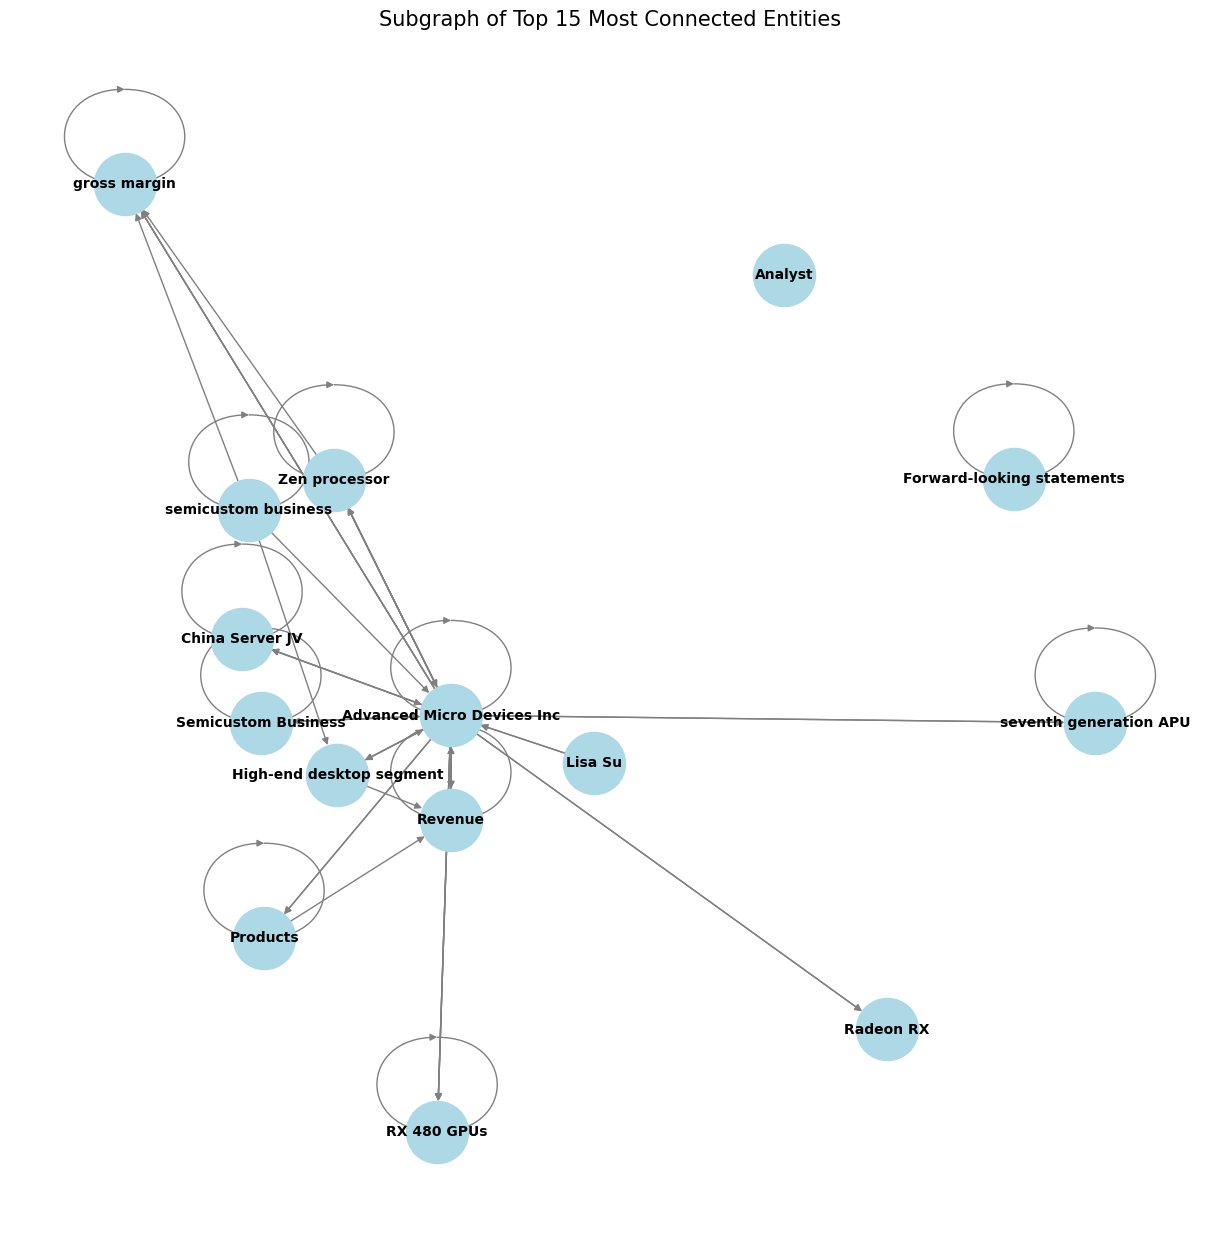

In [61]:
import matplotlib.pyplot as plt

print(f"Graph has {knowledge_graph.number_of_nodes()} nodes and {knowledge_graph.number_of_edges()} edges.")

# --- Inspect a sample node ---
# Let's find the node for "AMD"
amd_node_id = None
for node, data in knowledge_graph.nodes(data=True):
    if data.get('name', '').lower() == 'amd':
        amd_node_id = node
        break

if amd_node_id:
    print("\n--- Inspecting the 'AMD' node ---")
    print(f"Node ID: {amd_node_id}")
    print(f"Attributes: {knowledge_graph.nodes[amd_node_id]}")
    
    # --- Inspect edges connected to the "AMD" node ---
    print("\n--- Sample Outgoing Edges from 'AMD' ---")
    for i, (u, v, data) in enumerate(knowledge_graph.out_edges(amd_node_id, data=True)):
        if i >= 3: break # Show first 3
        object_name = knowledge_graph.nodes[v]['name']
        print(f"Edge {i+1}: AMD --[{data['predicate']}]--> {object_name}")
        print(f"  Statement: '{data['statement'][:80]}...'")
        print(f"  Valid From: {data['valid_at']}")

else:
    print("Could not find a node for 'AMD'.")

# --- Visualize a subgraph of the most connected nodes ---
# This helps to see the main entities and their relationships.
degrees = dict(knowledge_graph.degree())
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:15]

subgraph = knowledge_graph.subgraph(top_nodes)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, k=0.5, iterations=50)

# Get node labels from their 'name' attribute
labels = {node: data['name'] for node, data in subgraph.nodes(data=True)}

nx.draw(subgraph, pos, labels=labels, with_labels=True, node_color='lightblue', 
        node_size=2000, edge_color='gray', font_size=10, font_weight='bold')

plt.title("Subgraph of Top 15 Most Connected Entities", size=15)
plt.show()

In [ ]:
# It uses a "persona" to guide the LLM's output style.
initial_planner_system_prompt = (
    "You are an expert financial research assistant. Your task is to create a step-by-step plan "
    "for answering a user's question by querying a temporal knowledge graph of earnings call transcripts. "
    "The available tool is `factual_qa`, which can retrieve facts about an entity for a specific topic (predicate) "
    "within a given date range. Your plan should consist of a series of calls to this tool."
)

initial_planner_user_prompt_template = """
User Question: "{user_question}"

Based on this question, create a concise, step-by-step plan. Each step should be a clear action for querying the knowledge graph.

Return only the plan under a heading 'Research tasks'.
"""

planner_prompt = ChatPromptTemplate.from_messages([
    ("system", initial_planner_system_prompt),
    ("user", initial_planner_user_prompt_template),
])

# We'll use a powerful model for planning, as recommended.
planner_chain = planner_prompt | llm

# Let's test the planner with a sample question.
user_question = "How did AMD's focus on data centers evolve between 2016 and 2017?"

print(f"--- Generating plan for question: '{user_question}' ---")
plan_result = planner_chain.invoke({"user_question": user_question})
initial_plan = plan_result.content

print("\n--- Generated Plan ---")
print(initial_plan)

--- Generating plan for question: 'How did AMD's focus on data centers evolve between 2016 and 2017?' ---

--- Generated Plan ---
### Research tasks

1. Query `factual_qa` for AMD's statements or strategies related to data centers in 2016.  
   - Entity: AMD  
   - Topic: Data centers  
   - Date Range: January 1, 2016 - December 31, 2016  

2. Query `factual_qa` for AMD's statements or strategies related to data centers in 2017.  
   - Entity: AMD  
   - Topic: Data centers  
   - Date Range: January 1, 2017 - December 31, 2017  

3. Compare the results from 2016 and 2017 to identify changes in AMD's focus or strategy on data centers.  

4. Summarize the findings to explain how AMD's focus on data centers evolved between 2016 and 2017.


In [ ]:
from langchain_core.tools import tool
from datetime import date
import datetime as dt # Use alias to avoid confusion with the date object

def _as_datetime(ts) -> dt.datetime | None:
    if ts is None:
        return None
    if isinstance(ts, dt.datetime):
        return ts
    if isinstance(ts, dt.date):
        return dt.datetime.combine(ts, dt.datetime.min.time())
    for fmt in ("%Y-%m-%d", "%Y/%m/%d", "%Y-%m-%dT%H:%M:%S"):
        try:
            return dt.datetime.strptime(ts, fmt)
        except (ValueError, TypeError):
            continue
    return None

@tool
def factual_qa(entity: str, start_date: date, end_date: date, predicate: str) -> str:
    """
    Queries the knowledge graph for facts about a specific entity, topic (predicate),
    and time range. Returns a formatted string of matching relationships.
    """
    print(f"\n--- TOOL CALL: factual_qa ---")
    print(f"  - Entity: {entity}")
    print(f"  - Date Range: {start_date} to {end_date}")
    print(f"  - Predicate: {predicate}")

    # Convert input dates to timezone-aware datetimes for comparison
    start_dt = _as_datetime(start_date).replace(tzinfo=timezone.utc)
    end_dt = _as_datetime(end_date).replace(tzinfo=timezone.utc)

    # 1. Find the entity node in the graph
    target_node_id = None
    for node_id, data in knowledge_graph.nodes(data=True):
        if entity.lower() in data.get('name', '').lower():
            target_node_id = node_id
            break
            
    if not target_node_id:
        return f"Error: Entity '{entity}' not found in the knowledge graph."

    # 2. Search for matching edges
    matching_edges = []
    # Search both outgoing and incoming edges
    for u, v, data in list(knowledge_graph.out_edges(target_node_id, data=True)) + \
                      list(knowledge_graph.in_edges(target_node_id, data=True)):
        
        if predicate.upper() in data.get('predicate', '').upper():
            valid_at = data.get('valid_at')
            if valid_at:
                # Ensure valid_at is a timezone-aware datetime for comparison
                if not valid_at.tzinfo:
                    valid_at = valid_at.replace(tzinfo=timezone.utc)
                
                if start_dt <= valid_at <= end_dt:
                    subject_name = knowledge_graph.nodes[u]['name']
                    object_name = knowledge_graph.nodes[v]['name']
                    matching_edges.append(
                        f"Fact: {subject_name} --[{data['predicate']}]--> {object_name} "
                        f"(Statement: '{data['statement'][:100]}...')"
                    )

    if not matching_edges:
        return f"No facts found for entity '{entity}' with predicate '{predicate}' between {start_date} and {end_date}."
        
    return "\n".join(matching_edges)

# Let's test the tool directly
test_result = factual_qa.invoke({
    "entity": "AMD",
    "predicate": "LAUNCHED",
    "start_date": dt.date(2016, 1, 1),
    "end_date": dt.date(2017, 12, 31)
})

print("\n--- Tool Test Result ---")
print(test_result)


--- TOOL CALL: factual_qa ---
  - Entity: AMD
  - Date Range: 2016-01-01 to 2017-12-31
  - Predicate: LAUNCHED

--- Tool Test Result ---
No facts found for entity 'AMD' with predicate 'LAUNCHED' between 2016-01-01 and 2017-12-31.


In [69]:
# The corrected import is for ToolNode.
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage

# 1. Set up the tools for the ToolNode
tools = [factual_qa]

# The AgentState definition remains the same
class AgentState(TypedDict):
    messages: List[BaseMessage]

# 2. Define the agent nodes
def should_continue(state: AgentState) -> str:
    last_message = state['messages'][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "continue"
    return "end"

def call_model(state: AgentState):
    print("\n--- AGENT: Calling model... ---")
    response = llm_with_tools.invoke(state['messages'])
    return {"messages": [response]}

# 3. Wire up the agent graph
# =========================================================================
# === THIS IS THE LINE TO CHANGE ===
# We add .bind(tool_choice="any") to force the model to use a tool if it can.
llm_with_tools = llm.bind_tools(tools, tool_choice="any")
# =========================================================================

workflow = StateGraph(AgentState)

# Define the nodes
workflow.add_node("agent", call_model)
workflow.add_node("action", ToolNode(tools))

# Define the edges
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)
workflow.add_edge("action", "agent")

retrieval_agent = workflow.compile()
print("Retrieval agent graph compiled successfully with tool_choice parameter.")

Retrieval agent graph compiled successfully with tool_choice parameter.


In [71]:
# This code block does not need any changes.
initial_message = HumanMessage(
    content=f"Here is my question: '{user_question}'\n\n"
            f"Here is the plan to follow:\n{initial_plan}"
)

agent_input = {"messages": [initial_message]}

print("\n--- Running the full retrieval agent (with tool_choice) ---")

# Stream the agent's execution
async for output in retrieval_agent.astream(agent_input):
    for key, value in output.items():
        if key == "agent":
            agent_message = value['messages'][-1]
            if agent_message.tool_calls:
                print(f"LLM wants to call a tool: {agent_message.tool_calls[0]['name']}")
            else:
                print("\n--- AGENT: Final Answer ---")
                print(agent_message.content)
        elif key == "action":
            print("--- AGENT: Tool response received. ---")


--- Running the full retrieval agent (with tool_choice) ---

--- AGENT: Calling model... ---
LLM wants to call a tool: factual_qa

--- TOOL CALL: factual_qa ---
  - Entity: AMD
  - Date Range: 2016-01-01 to 2016-12-31
  - Predicate: strategies or statements related to data centers
--- AGENT: Tool response received. ---

--- AGENT: Calling model... ---
LLM wants to call a tool: factual_qa

--- TOOL CALL: factual_qa ---
  - Entity: AMD
  - Date Range: 2016-01-01 to 2016-12-31
  - Predicate: strategies or statements related to data centers
--- AGENT: Tool response received. ---

--- AGENT: Calling model... ---
LLM wants to call a tool: factual_qa

--- TOOL CALL: factual_qa ---
  - Entity: AMD
  - Date Range: 2016-01-01 to 2016-12-31
  - Predicate: strategies or statements related to data centers
--- AGENT: Tool response received. ---

--- AGENT: Calling model... ---
LLM wants to call a tool: factual_qa

--- TOOL CALL: factual_qa ---
  - Entity: AMD
  - Date Range: 2016-01-01 to 2016-12-3